<a href="https://colab.research.google.com/github/EvertonTrentoJR/FittingEIS2orderTF/blob/main/coef_minimization_EIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Second-Order Transfer Function Approach for Fitting Electrical Impedance Spectroscopy Data

**Author:  Everton Trento Jr**

This code implements a curve-fitting algorithm for electrical impedance spectroscopy (EIS) using second-order transfer-function modeling. Two approaches are implemented. The first uses synthetic data as input to the fitting algorithm and can be configured for first- or second-order models. The second uses experimental data acquired with a Keysight E4980A LCR impedance analyzer and a liquid test fixture that measures water as it freezes into ice at −5 °C.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.linalg import lstsq
import os
import pandas as pd
from google.colab import drive

# **Class Synthetic Data**

In [41]:
class InputDataSynthetic:
    def __init__(self, syntP=None, freq=None, order=None ):
        self.freq = freq
        self.order = order
        self.syntP = syntP
        self.generateSyntheticTF()
        self.plot_input_data()
        self.magphase_complex = {}

    def get_data(self):
      return self.mag_data, self.phase_data

    def generateSyntheticTF(self):
        self.H, self.mag_data, self.phase_data = coef2spectrum(self.syntP,self.freq, self.order)

    def plot_input_data(self):
        plt.figure(figsize=(12, 5))

        # Plot magnitude
        plt.subplot(1, 2, 1)
        plt.loglog(self.freq, self.mag_data, label='Measured Data', color='blue')
        plt.title('Magnitude Response (Synthetic Data)')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('|H(jω)|')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.legend()

        # Plot phase
        plt.subplot(1, 2, 2)
        plt.semilogx(self.freq, self.phase_data, label='Measured Data', color='green')
        plt.title('Phase Response (Synthetic Data)')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('∠H(jω) [rad]')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def magphase_to_complex(self):
        self.magphase_complex = self.mag_data * np.exp(1j * self.phase_data)
        return self.magphase_complex


# **Class Experimental Data**

In [42]:
class InputDataExperimental:
  def __init__(self, freq=None ):
      self.freq = freq
      self.results = {}
      self.mag_file = {}
      self.mag_data = {}
      self.phase_data = {}
      self.magphase_complex = {}

  def experimental(self):
    drive.mount('/content/drive')
    path = '/content/drive/My Drive/Signals&systems finals/ICE_test_03_09_25/'
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

    for file in csv_files:
      full_path = os.path.join(path, file)
      print(f"Reading.... {full_path}")
      df = pd.read_csv(full_path)
      df = df.iloc[:, 1:]
      self.results[file] = df.mean(numeric_only=True)

    self.summary = pd.DataFrame(self.results)
    return self.summary

  def get_data(self):
    self.mag_data.clear()
    self.phase_data.clear()

    for file, vals in self.results.items():
        # ensure even length: pairs (Z, TD) for each frequency
        if vals.size % 2 != 0:
            vals = vals[:-1]
        self.mag_file[file] = vals[0::2]  # Z
        self.phase_data[file] = vals[1::2]  # TD (deg)
        self.mag_data[file] = np.abs(self.mag_file[file]) # Z in dB

    return self.mag_data, self.phase_data

  def magphase_to_complex(self):
    self.magphase_complex.clear()
    for file in self.mag_data.keys():
      self.magphase_complex[file] = np.asarray(self.mag_data[file]) * np.exp(1j * np.asarray(self.phase_data[file]) * np.pi/180) # Convert phase to radians
    return self.magphase_complex

  def plot_input_data(self):
    files = sorted(set(self.mag_data) & set(self.phase_data))

    for file in files:
      print("Plot experimental data:  ")

      plt.figure(figsize=(12, 5))
      plt.suptitle(f'Experimental Data: {file}')
      # Magnitude
      plt.subplot(1, 2, 1)
      plt.loglog(self.freq, self.mag_data[file], label=f'{file}', marker='o')
      plt.title('Magnitude Response (Experimental Data)')
      plt.xlabel('Frequency [Hz]')
      plt.ylabel('|H(jω)|')
      plt.grid(True, which='both', linestyle='--', alpha=0.5)
      plt.legend()

      # Phase
      plt.subplot(1, 2, 2)
      plt.semilogx(self.freq, self.phase_data[file], label=f'{file}', marker='x')
      plt.title('Phase Response (Experimental Data)')
      plt.xlabel('Frequency [Hz]')
      plt.ylabel('∠H(jω) [deg]')
      plt.grid(True, which='both', linestyle='--', alpha=0.5)
      plt.legend()

      plt.tight_layout()
      plt.show()

# **Define Loss Function**

In [142]:
# ---- coef2spectrum function ---- #
# applies the  coeficients and calculate the phase and magnitude
def coef2spectrum(params,freq,order=2):

  w = 2 * np.pi * np.asarray(freq, dtype=float)
  jw = 1j * w

  if order == 2:
        a0, a1, a2, b0, b1, b2  = params
        num = b0 + b1 * jw + b2 * jw**2
        den = a0 + a1 * jw + a2 * jw**2
        H = num / den
  else:
      a0, a1, b0, b1 = params
      H = (b0 + b1 * jw)/ (a0 + a1 * jw)

  mag = np.abs(H)
  phase = np.angle(H)

  return H, mag, phase

# ---- loss_function_complex function ---- #
# calculate the loss between fitted data and the reference data
def loss_function_complex(params, freq, magphase_complex, order=2, plotloss = None):

    H,_,_ = coef2spectrum(params,freq,order=2)

    # Compare complex values in linear units
    diff = H - np.asarray(magphase_complex)

    loss = np.linalg.norm(diff)**2/len(freq)
    print(f"Loss: {loss}")

    if plotloss:
      plt.figure(figsize=[10,5])
      plt.loglog(freq, np.abs(magphase_complex), label='Input Data', color='blue')
      plt.loglog(freq, np.abs(H), label='Fitted Data', color='red',linestyle=':')
      plt.title(f'Magnitude Response Input vs. Fitted Data - Loss: {loss}')
      plt.xlabel('Frequency [Hz]')
      plt.ylabel('|H(jω)|')
      plt.grid(True, which='both', linestyle='--', alpha=0.5)
      plt.legend()
      plt.show()

    return loss

# ---- pltFit function ---- #
# plot fitted data and reference data over the frequency spectrum,
# magnitude as loglog and phase as logx
def pltFit(freq, mag_data, mag_fit, phase_data, phase_fit):

  mag_data = 20 * np.log10(mag_data)
  mag_fit = 20 * np.log10(mag_fit)

  # plot Magnitude and Phase for fitted and raw data
  plt.figure(figsize=(12, 5))

  # Plot magnitude
  plt.subplot(1, 2, 1)
  plt.loglog(freq, mag_data, label='Measured Data', color='blue')
  plt.loglog(freq, mag_fit, label='Fitted Data', color='red',linestyle=':')
  plt.title('Magnitude Response (Input Data)')
  plt.xlabel('Frequency [Hz]')
  plt.ylabel('|H(jω)|')
  plt.grid(True, which='both', linestyle='--', alpha=0.5)
  plt.legend()

  # Plot phase
  plt.subplot(1, 2, 2)
  plt.semilogx(freq, phase_data, label='Measured Data', color='green')
  plt.semilogx(freq, phase_fit, label='Fitted Data', color='red',linestyle=':')
  plt.title('Phase Response (Input Data)')
  plt.xlabel('Frequency [Hz]')
  plt.ylabel('∠H(jω) [rad]')
  plt.grid(True, which='both', linestyle='--', alpha=0.5)
  plt.legend()

  plt.tight_layout()
  plt.show()

In [5]:
freq = np.logspace(np.log10(40), 6, 201)  # 40 Hz to 1 MHz in 201 points
order = 2

# **Create Synthetic Data**

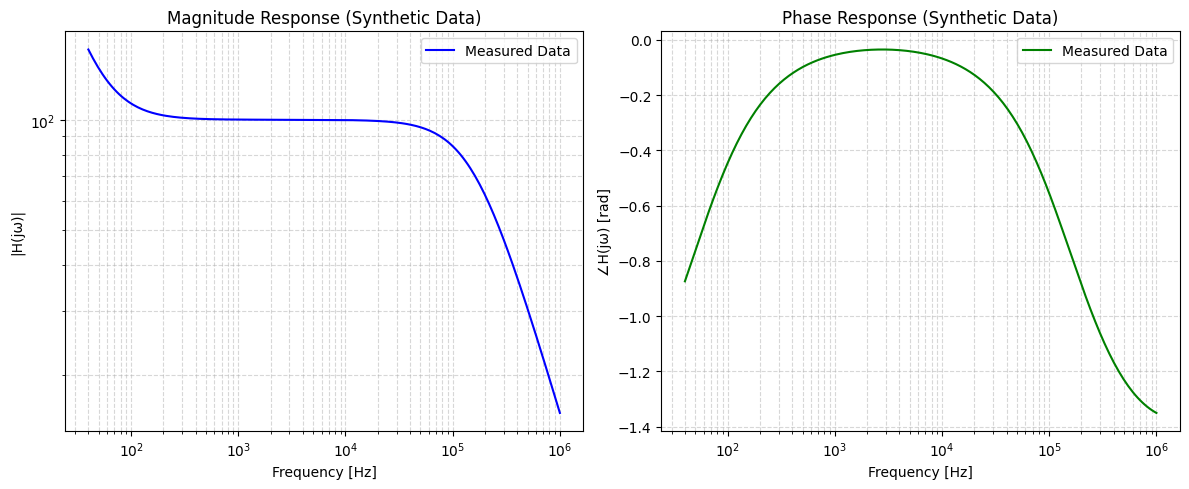

In [89]:
# syntheticParams = [1.0, 0.0, 1e-6, 10.0] # a0, a1, b0, b1 for first order TF
# syntheticParams  = [1.0, 0.0, 1e-6, 0.0, 10.0, 1e6]  # a0, a1, a2, b0, b1, b2 for second order TF

k = 1e8

syntheticParams  = [0.0, 10e5, 1, 300*k, k, 1] # lokalike experimental data
input_data_synt = InputDataSynthetic(syntP=syntheticParams, freq=freq, order=order)

mag_data, phase_data = input_data_synt.get_data()

magphase_complex = input_data_synt.magphase_to_complex()

# **Load Experimental Data**

In [ ]:
input_exp = InputDataExperimental(freq=freq)

summary = input_exp.experimental()

mag_exp, phase_exp = input_exp.get_data()

input_exp.plot_input_data()

magphase_complex_exp = input_exp.magphase_to_complex()

# **Testing loss function**


In [143]:
k = 1e8

a0 = 0.0
a1 = 10e5
a2 = 1
b0 = 300.0*k
b1 = k
b2 = 1

params = [a0, a1, a2, b0, b1, b2]
loss = loss_function_complex(params, freq, magphase_complex, order=2)

Loss: 8.863990427683014e-29


**a Parameters**

Parameter A0:


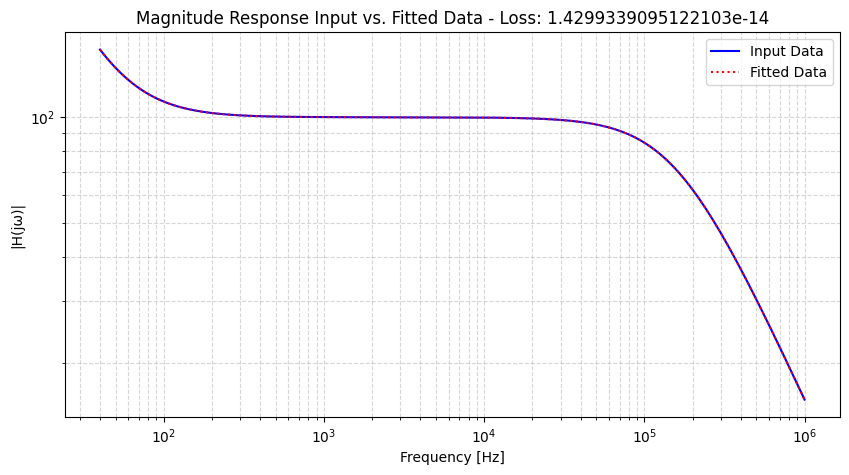

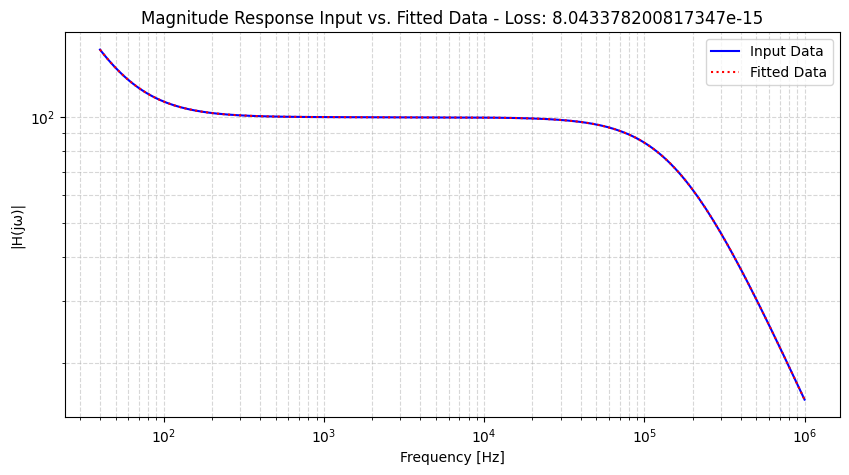

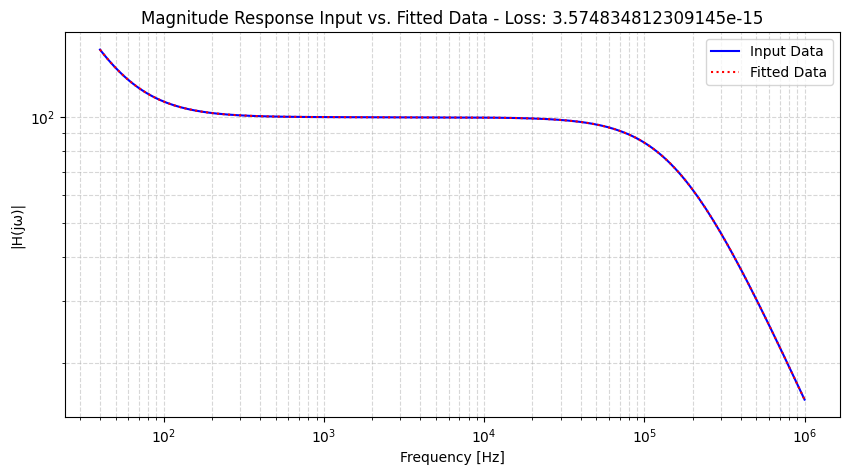

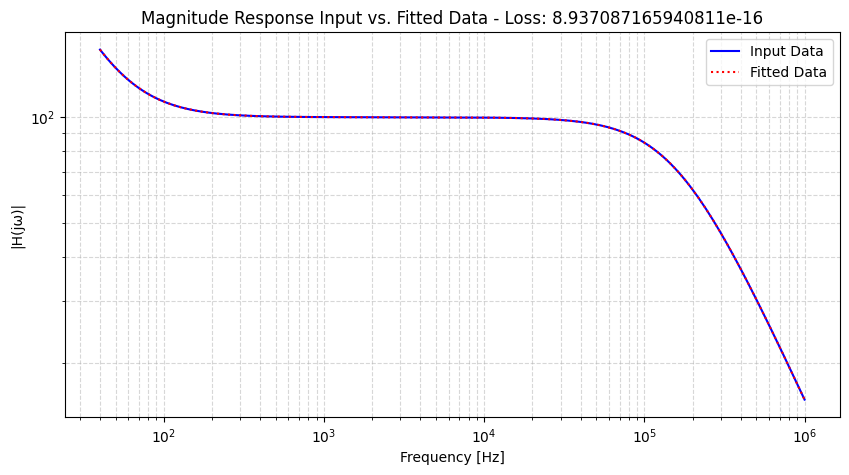

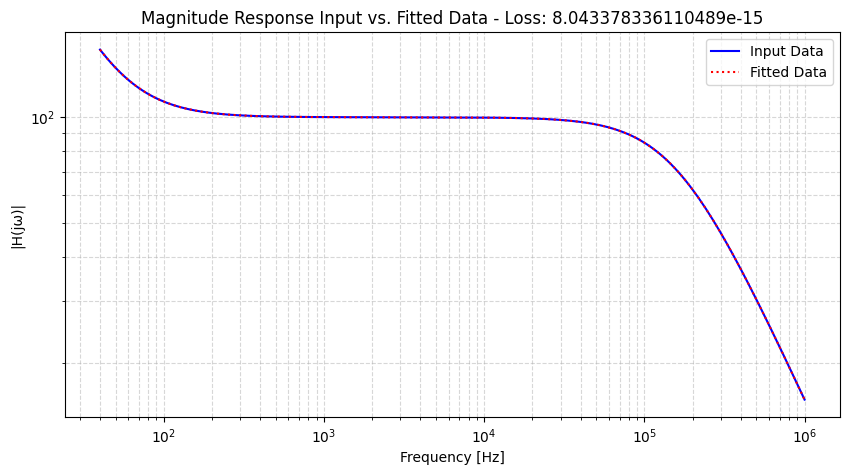

Parameter A1:


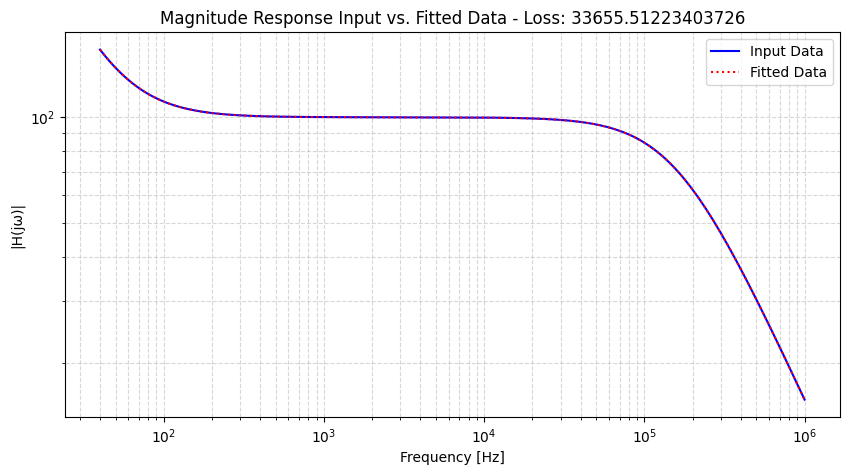

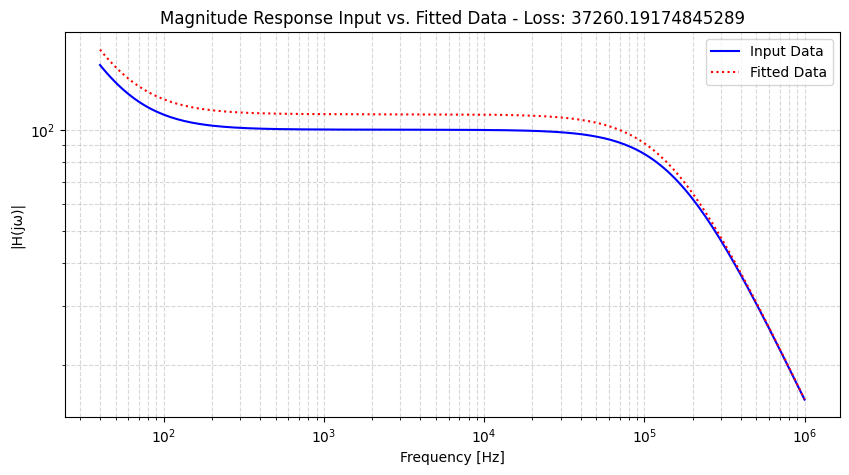

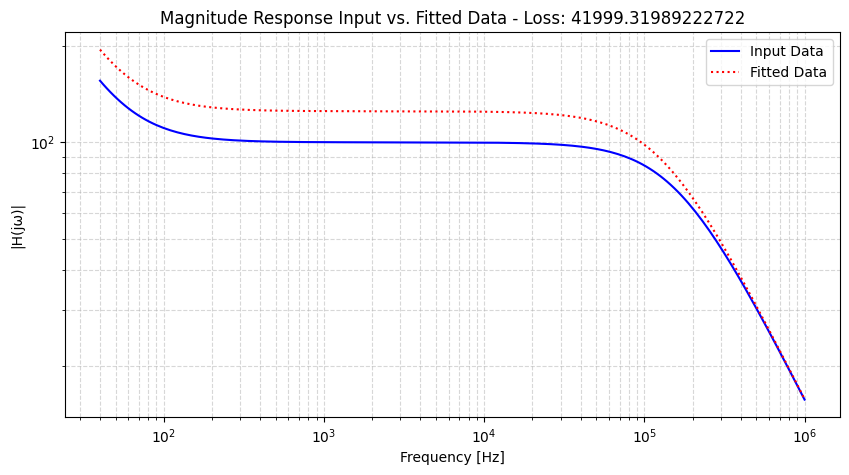

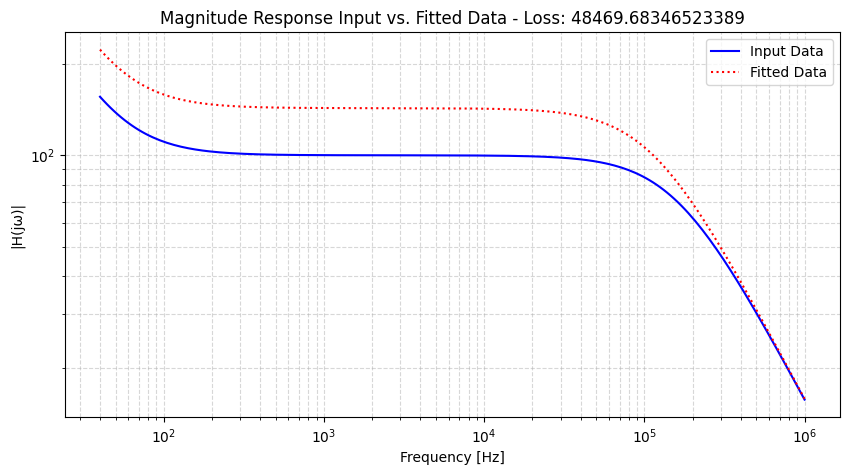

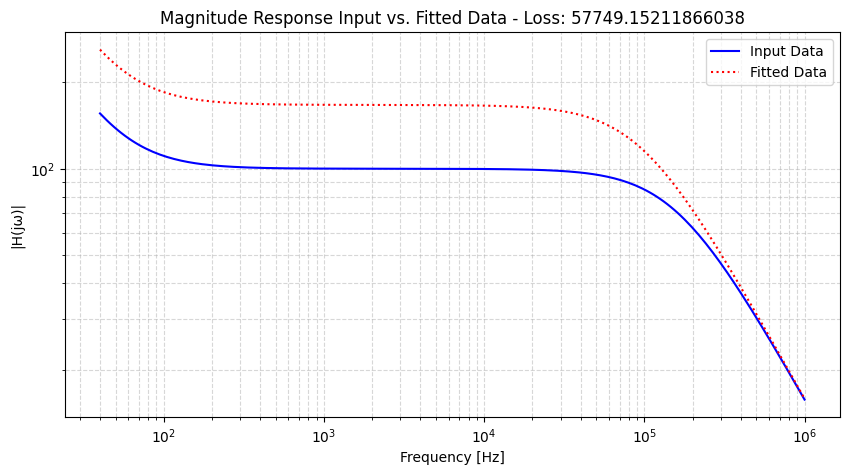

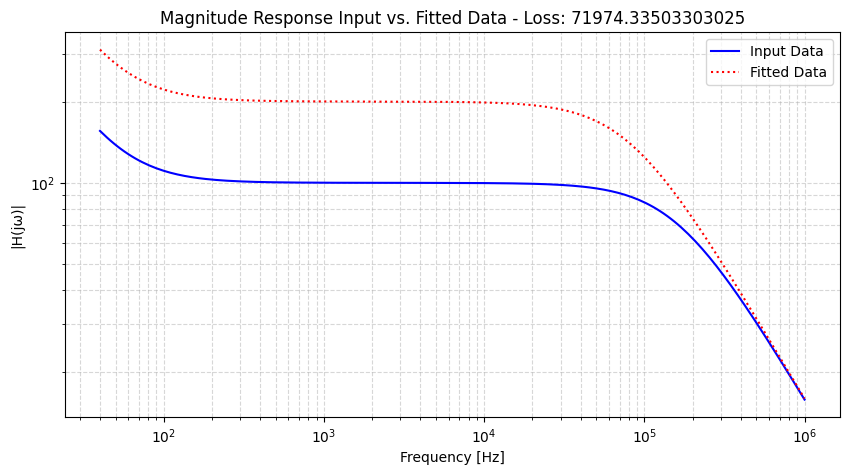

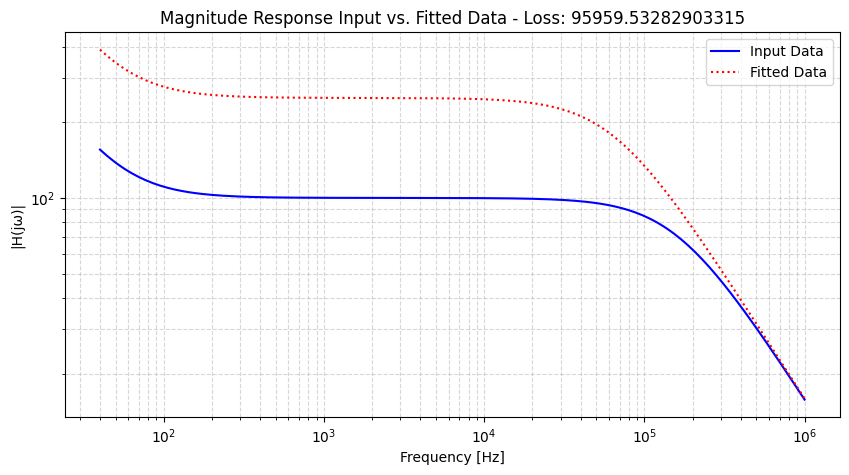

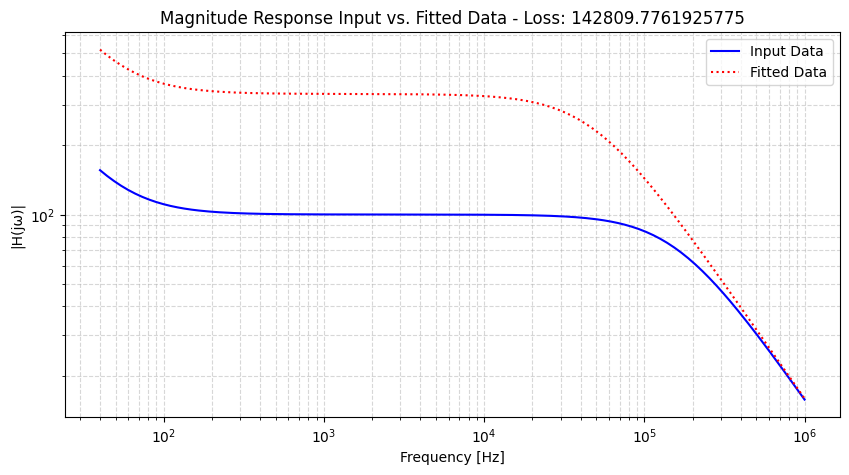

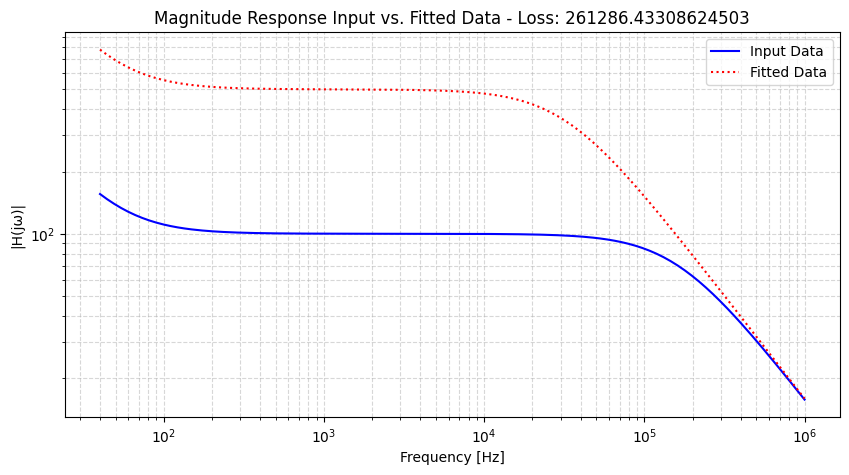

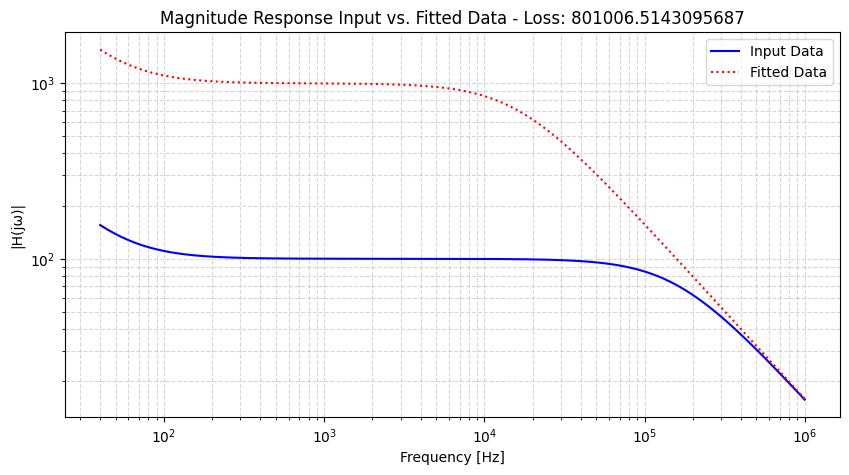

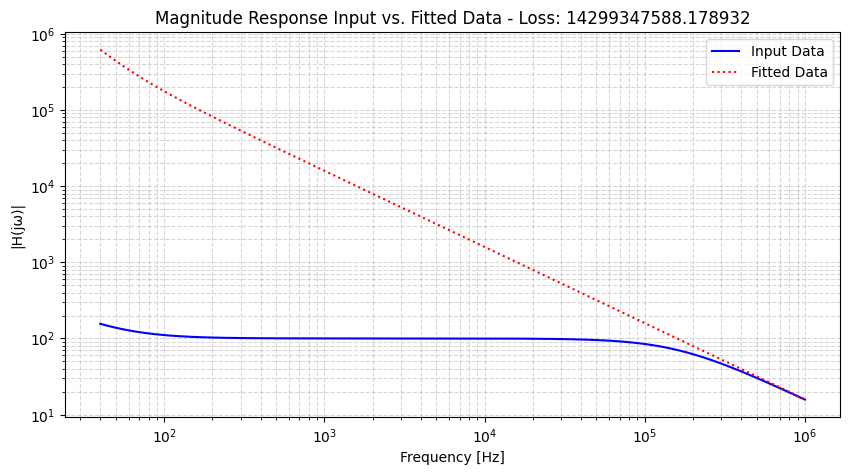

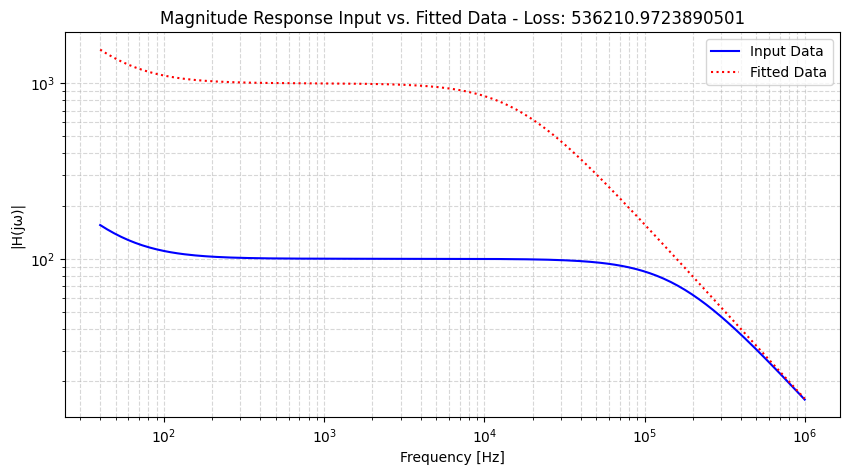

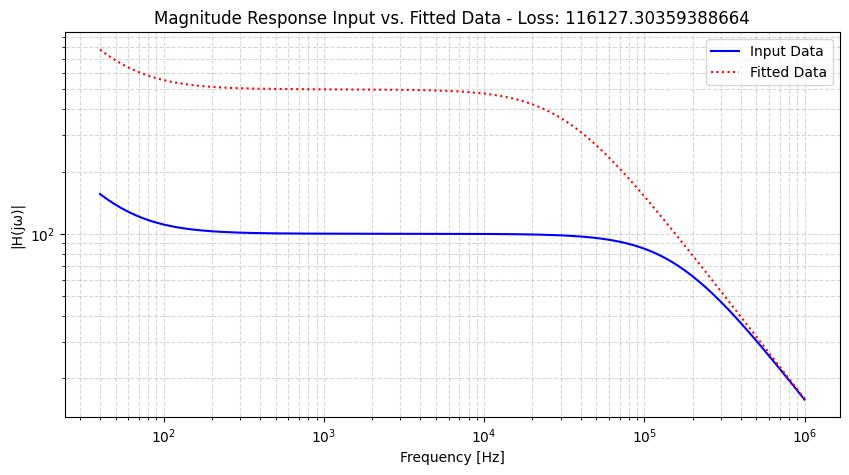

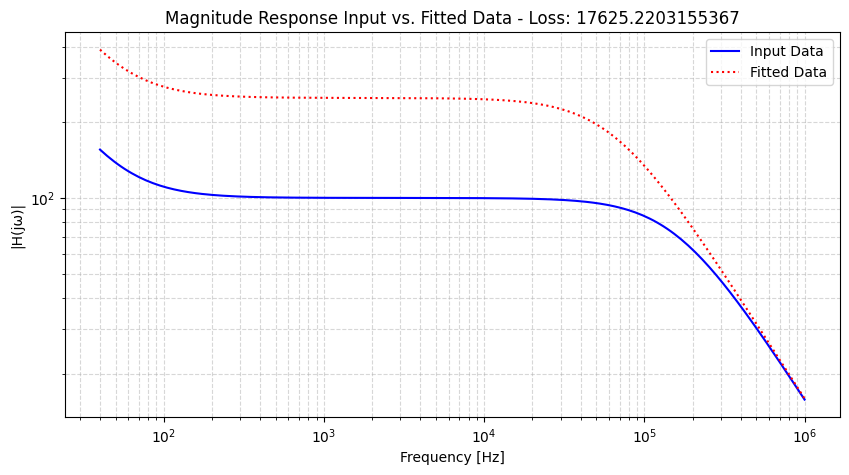

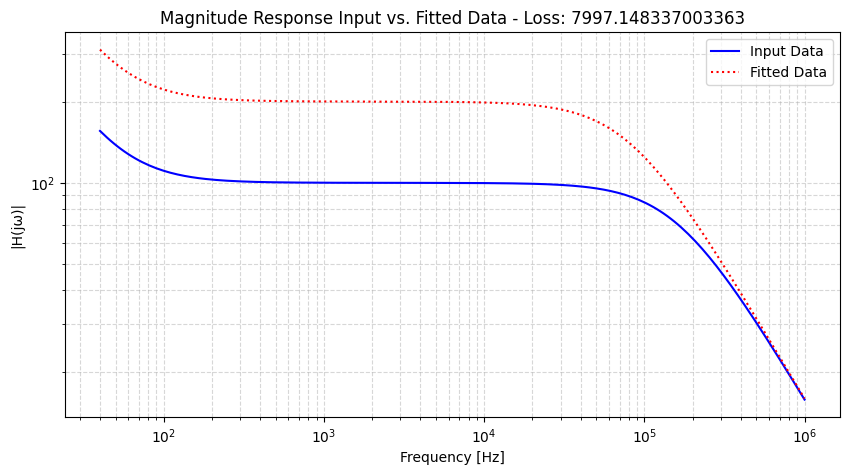

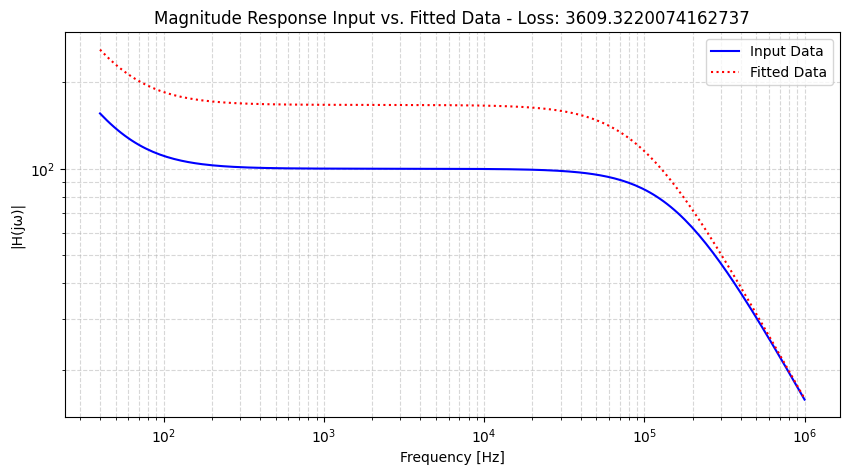

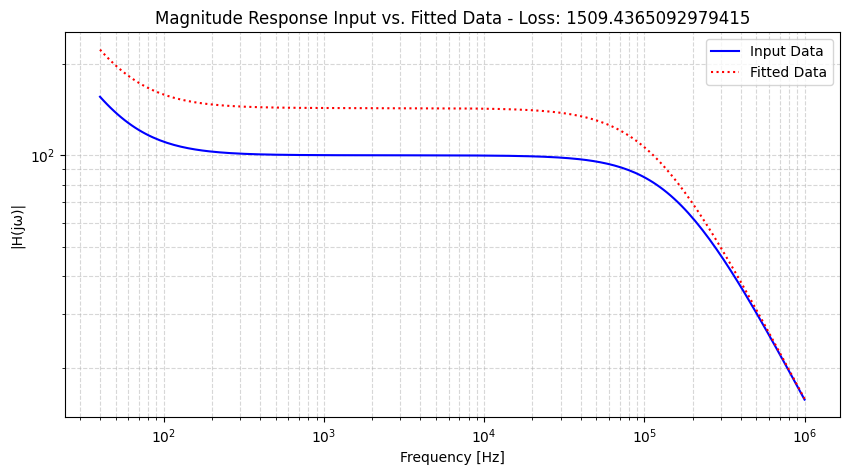

Parameter A2:


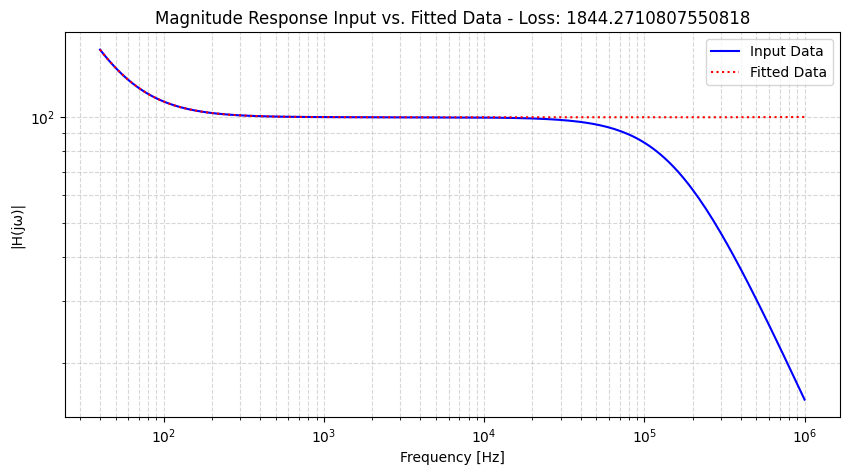

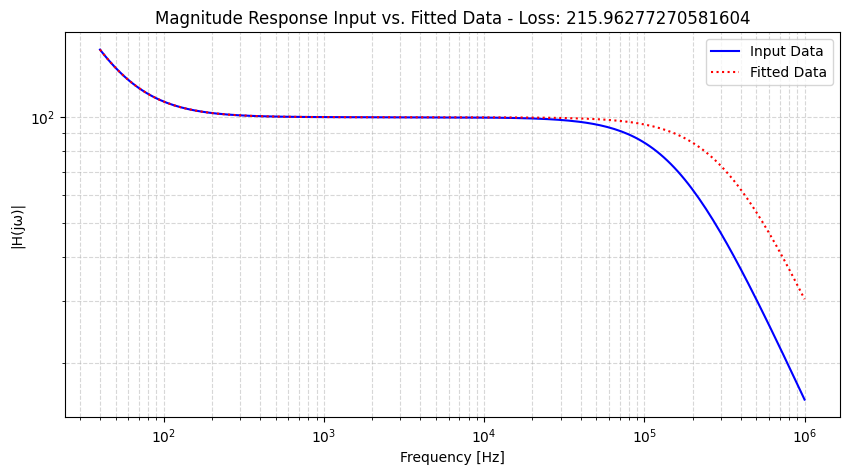

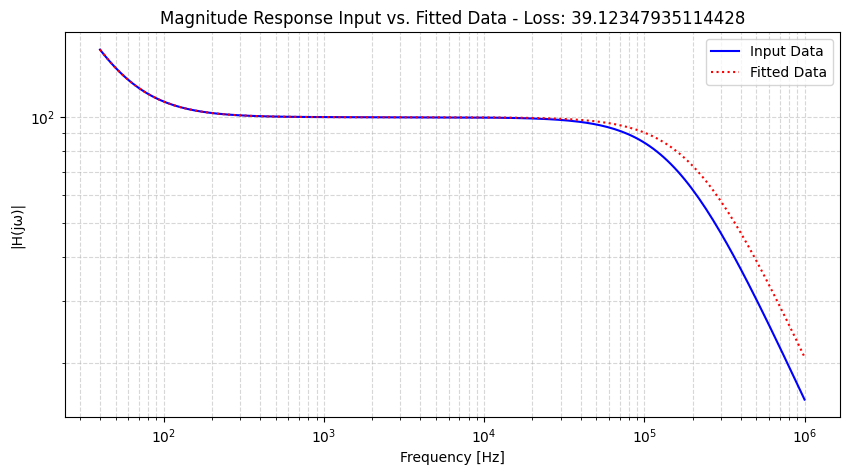

In [93]:
# param A0
a0_span = np.arange(-1, 1, 0.25)
losses_a0 = []
print("Parameter A0:")
for val in a0_span:
    test_params = [val, a1, a2, b0, b1, b2]
    loss_a0 = loss_function_complex(test_params, freq, magphase_complex, order=2, plotloss=True)
    losses_a0.append(loss_a0)

# param A1
a1_span = np.arange(-10e5, 10e5, 1e5)
losses_a1 = []
print("Parameter A1:")
for val in a1_span:
    test_params = [a0, val, a2, b0, b1, b2]
    loss_a1 = loss_function_complex(test_params, freq, magphase_complex, order=2,plotloss=True)
    losses_a1.append(loss_a1)

# param A2
a2_span  = np.arange(0, 1, 0.25)
losses_a2 = []
print("Parameter A2:")
for val in a2_span:
    test_params = [a0, a1, val, b0, b1, b2]
    loss_a2 = loss_function_complex(test_params, freq, magphase_complex, order=2,plotloss=True)
    losses_a2.append(loss_a2)


b Parameters

Parameter B0:


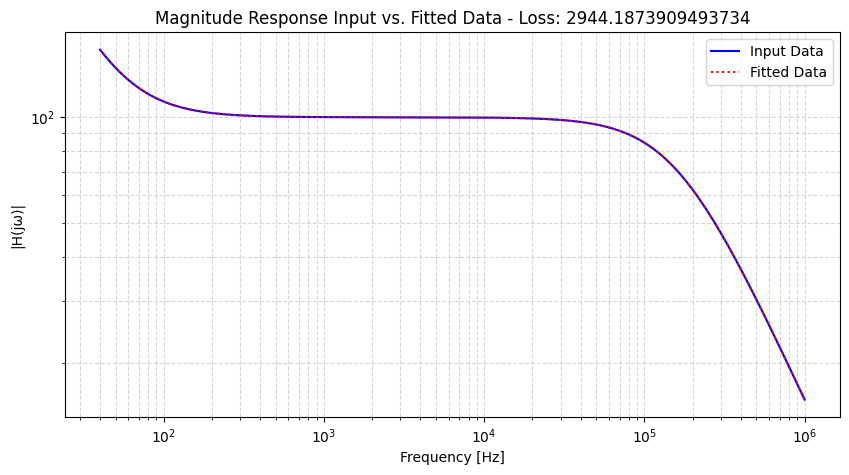

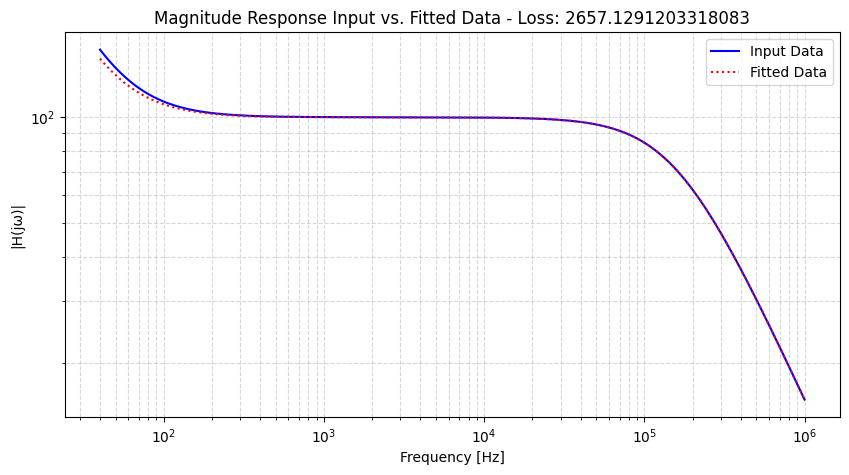

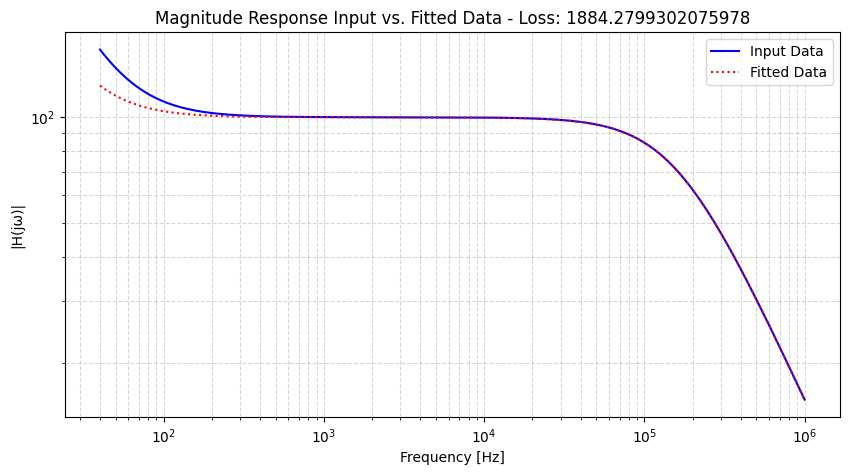

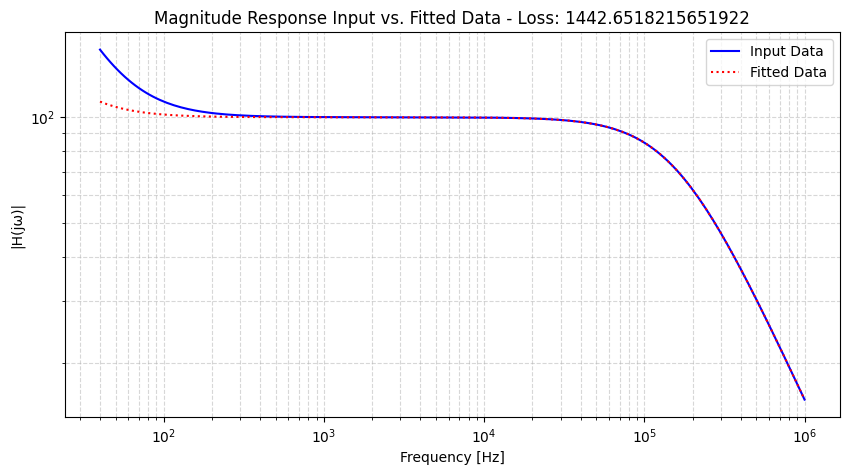

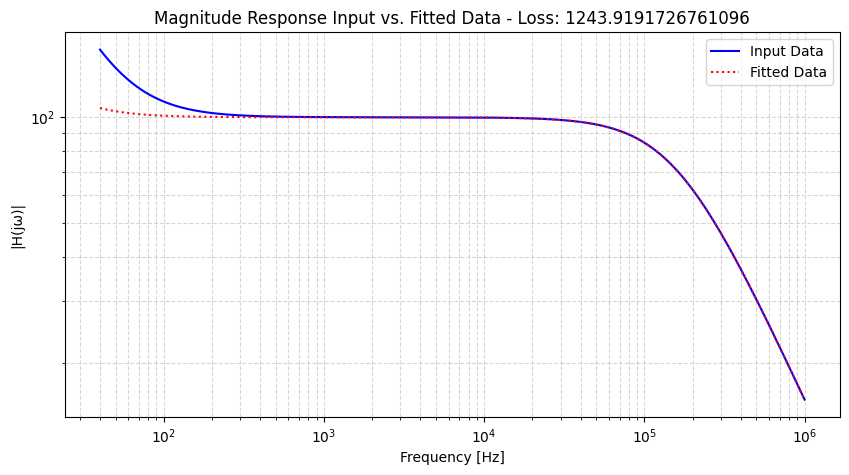

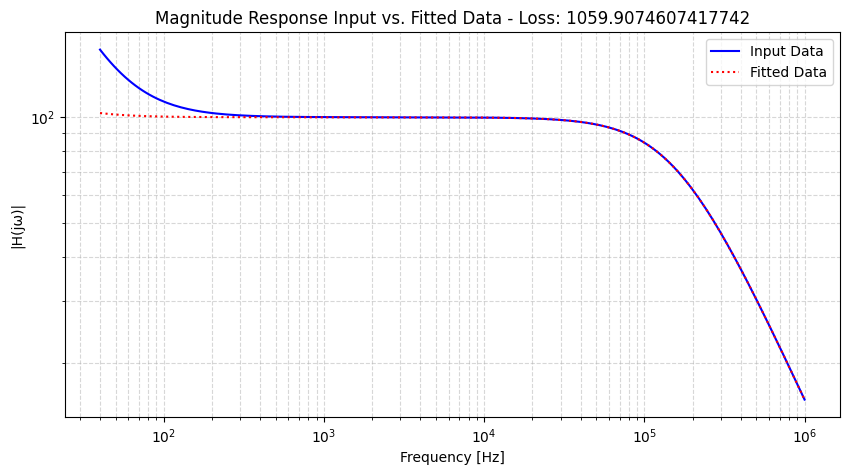

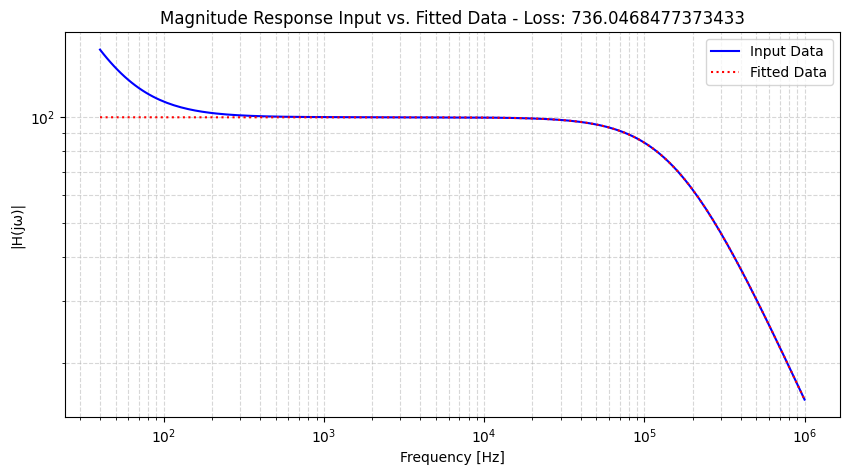

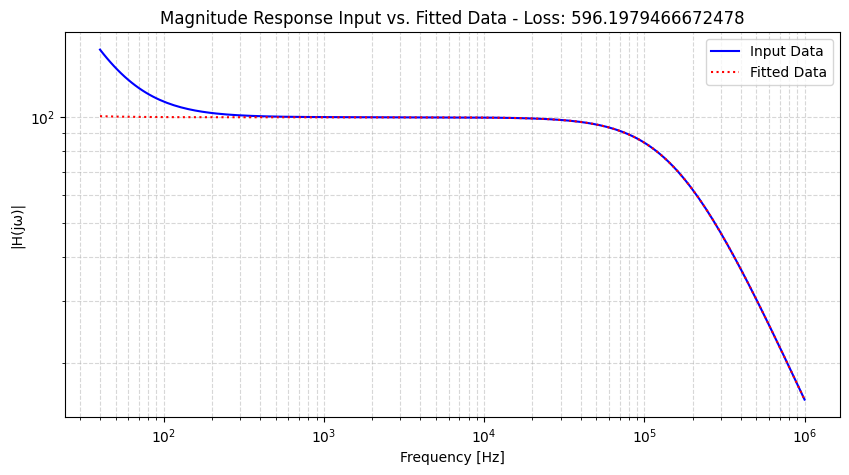

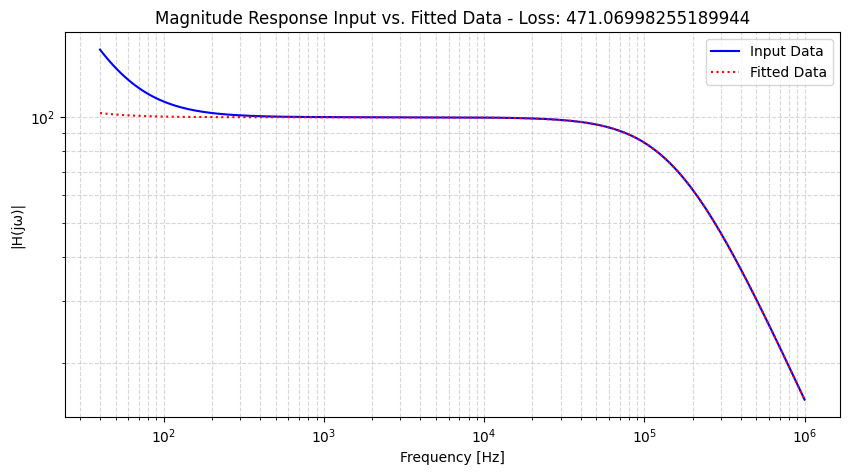

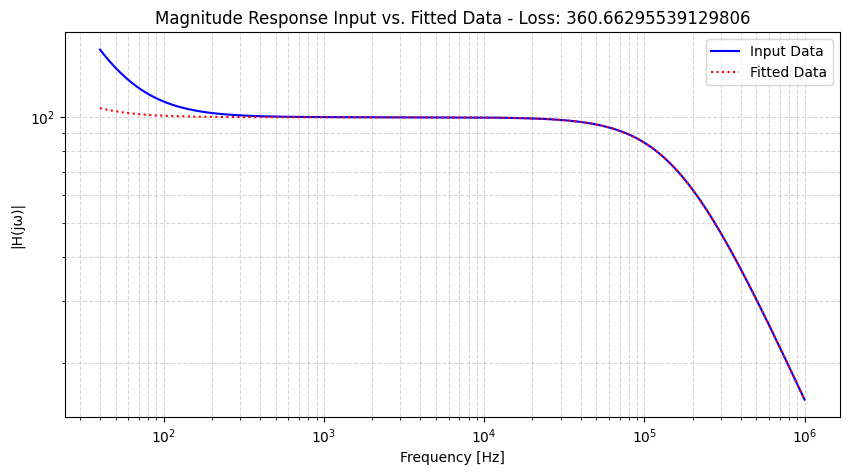

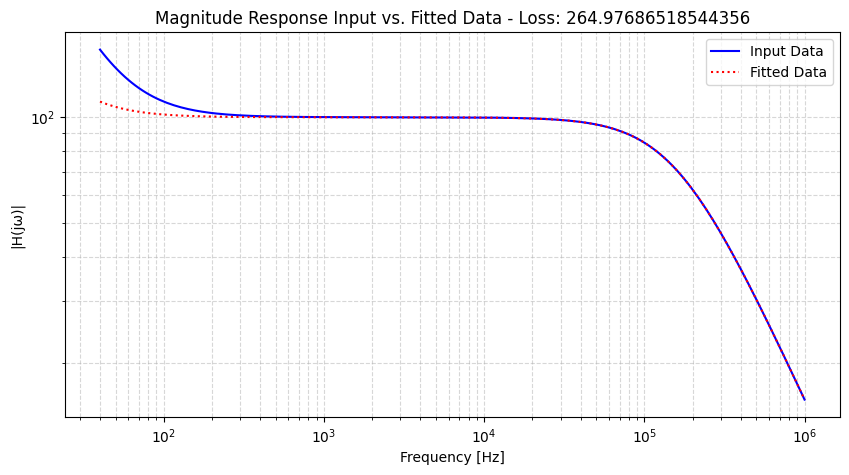

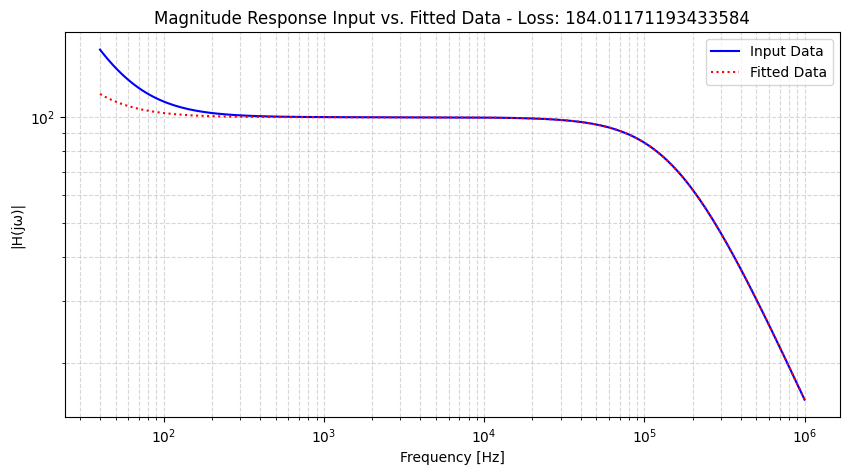

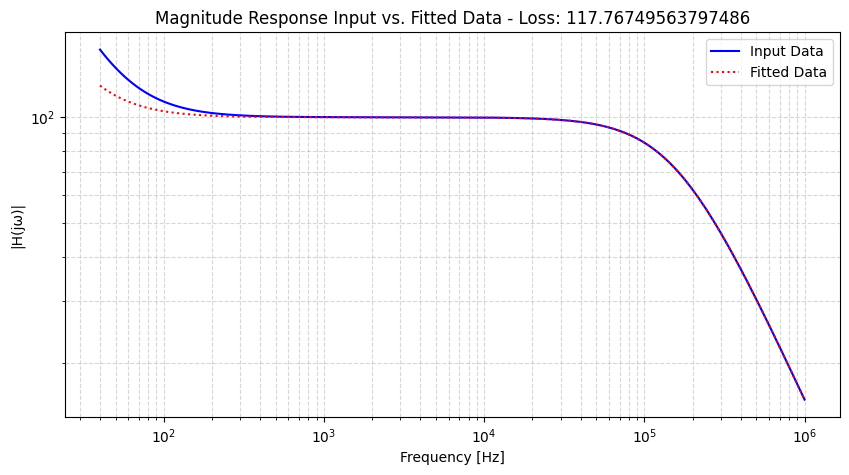

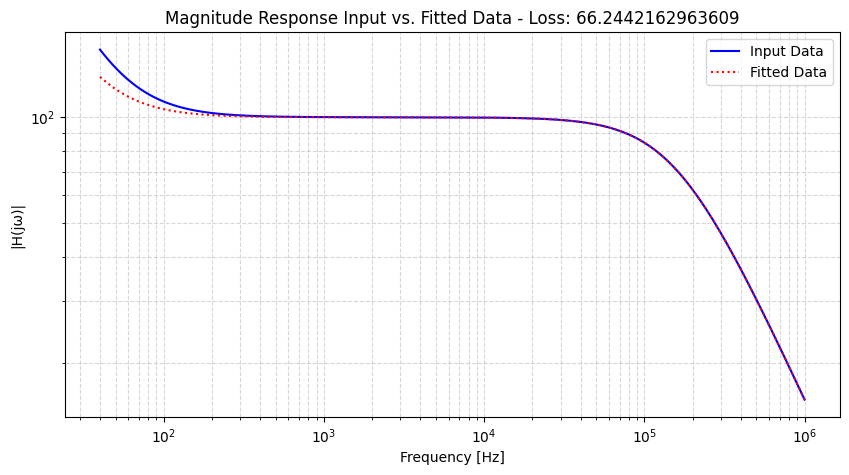

Parameter B1:


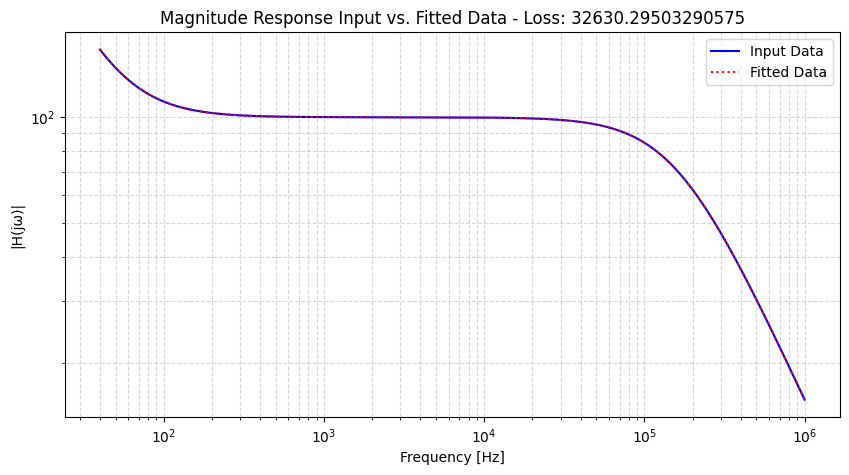

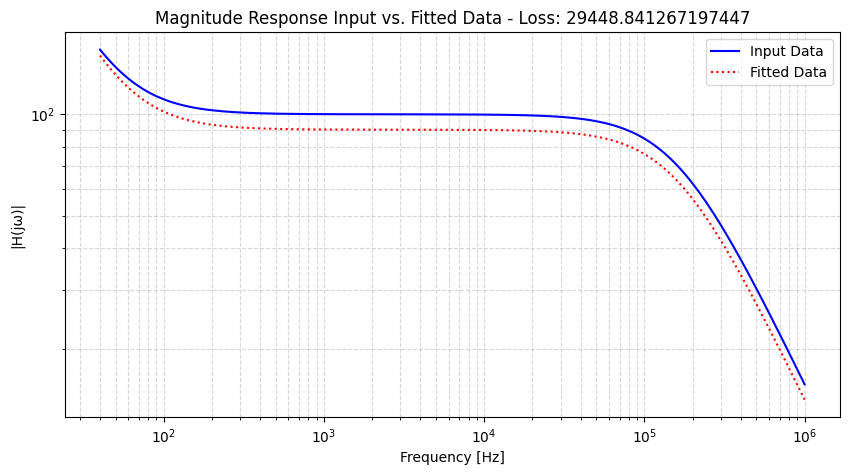

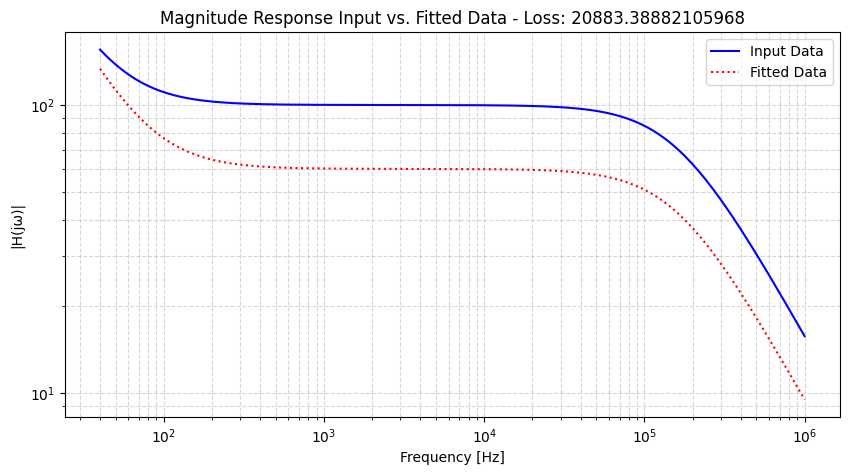

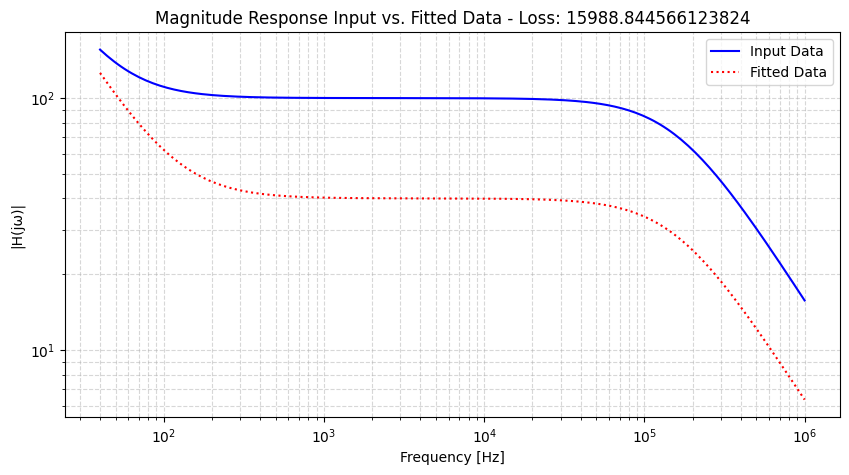

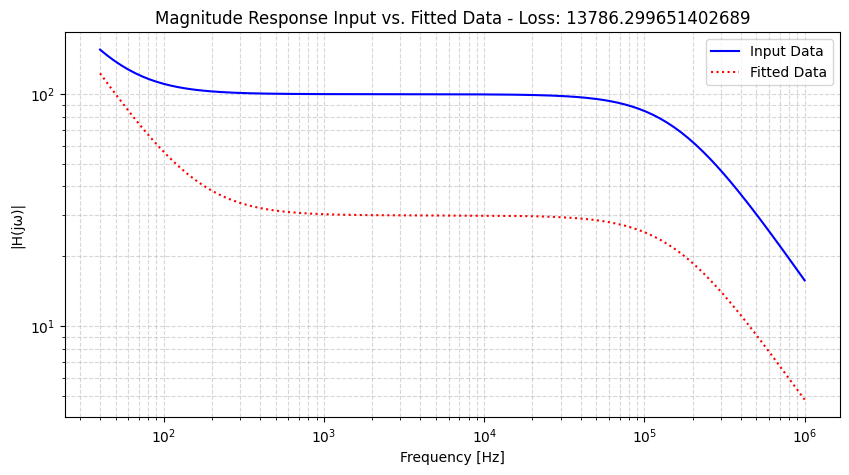

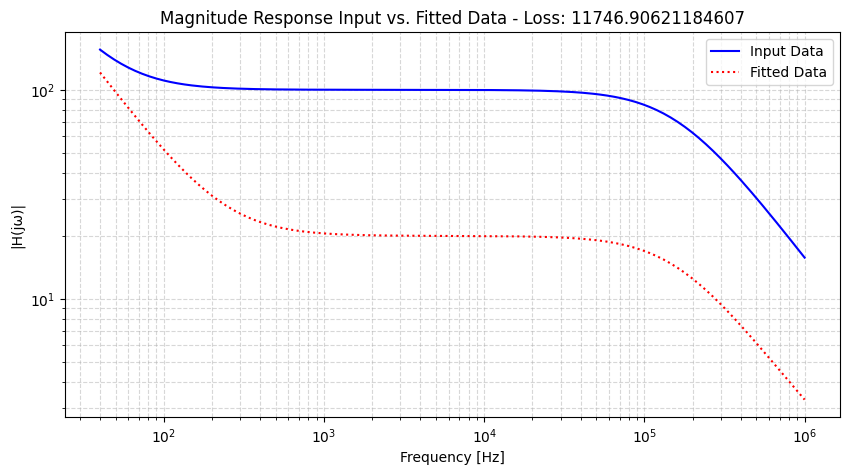

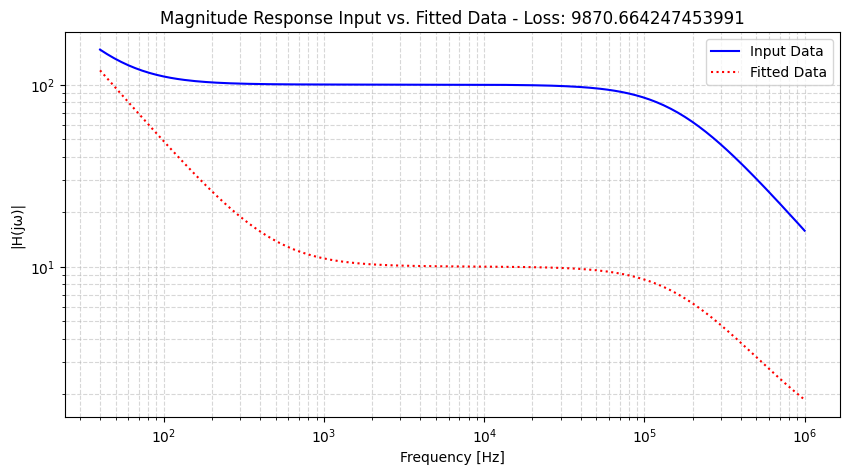

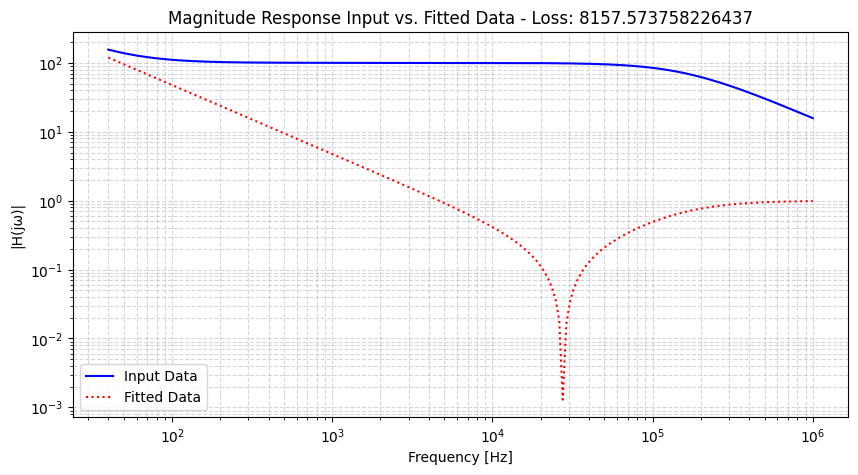

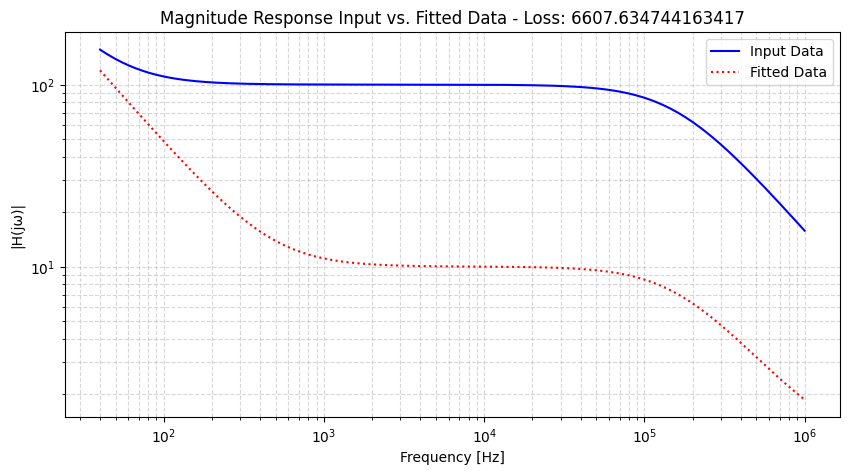

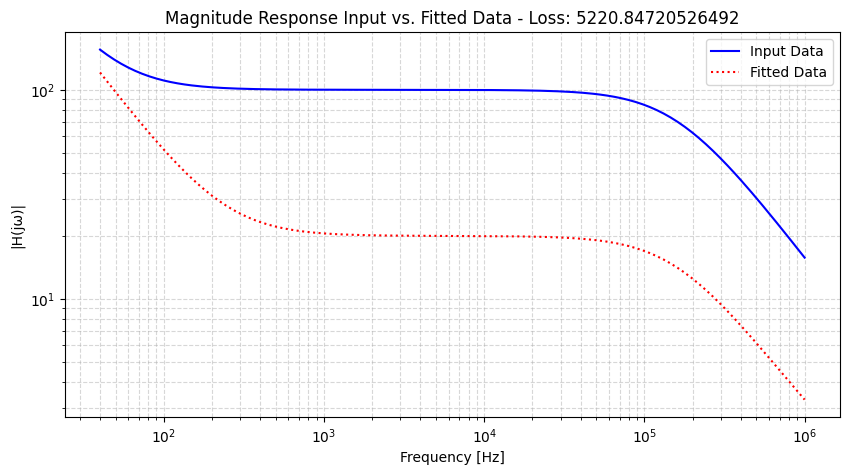

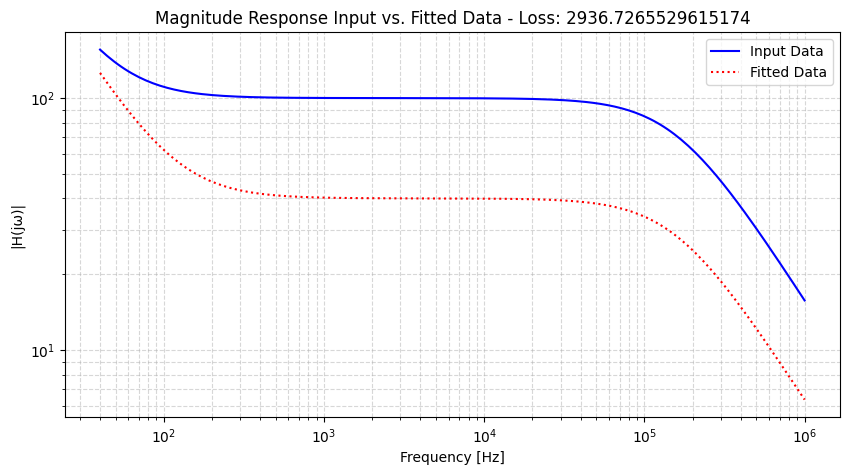

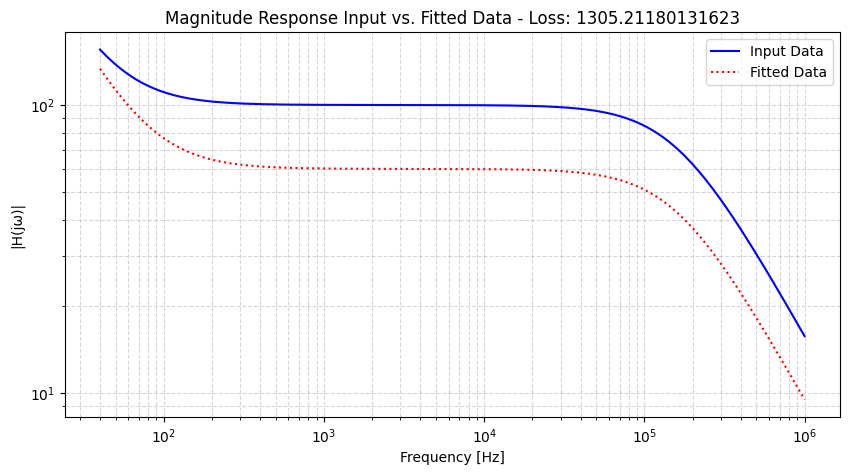

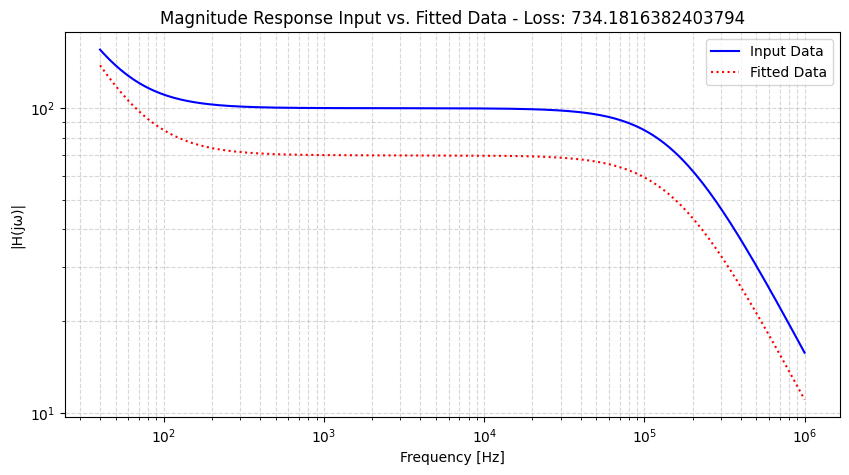

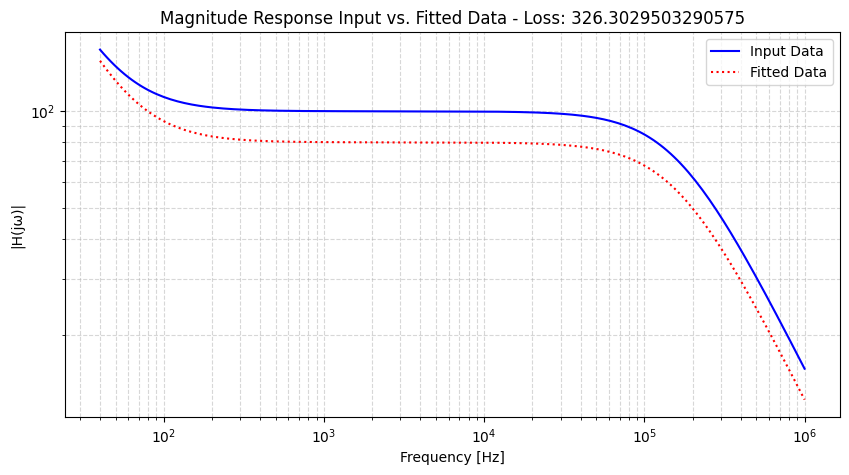

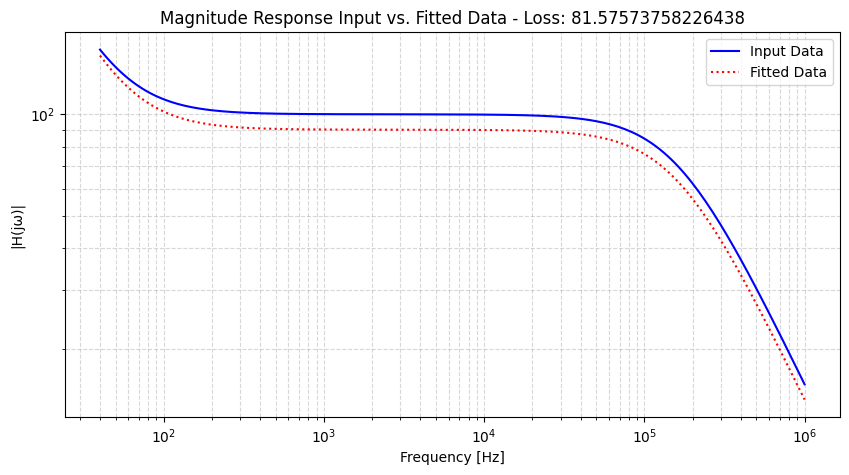

Parameter B2:


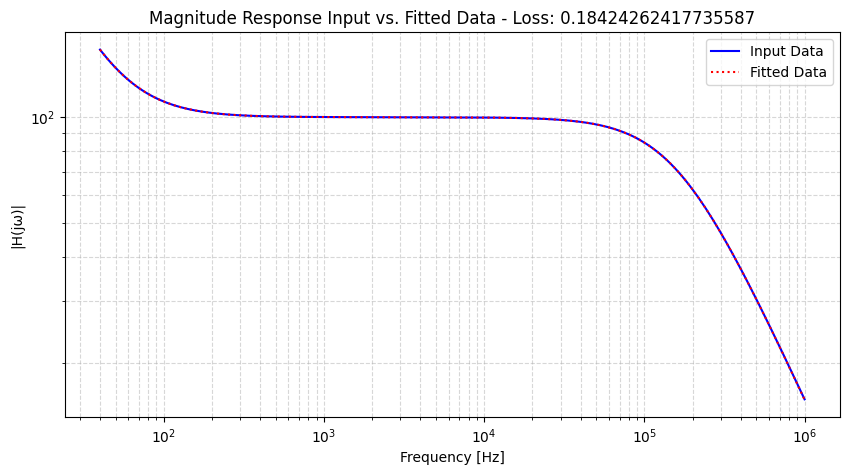

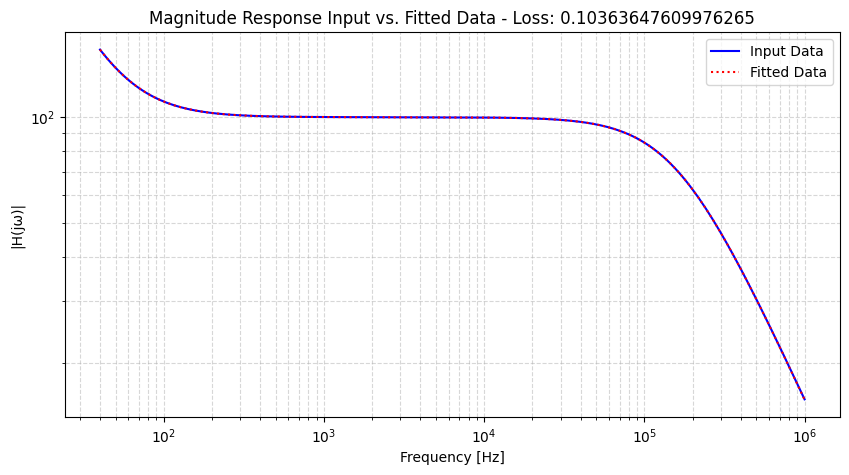

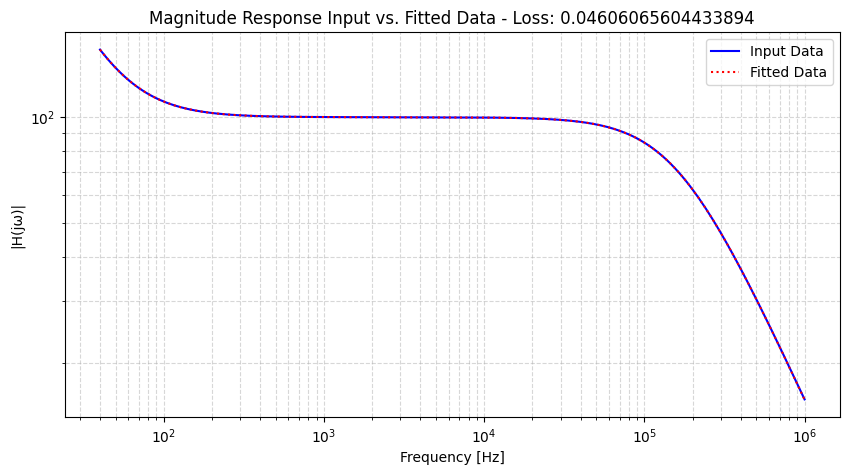

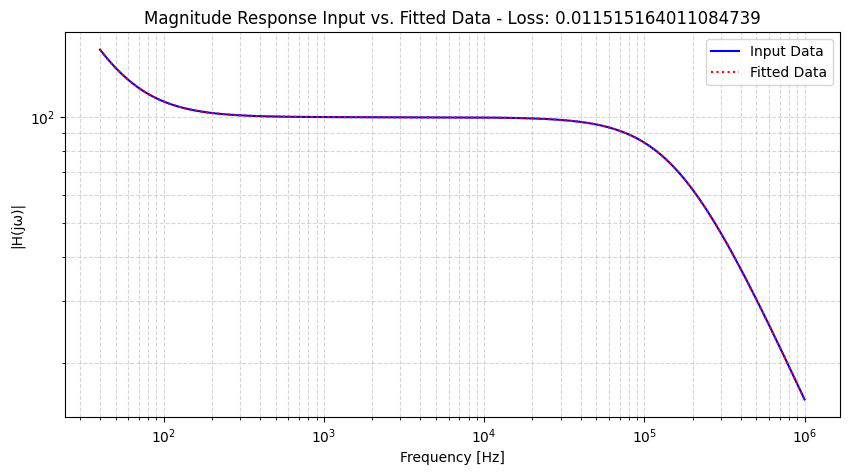

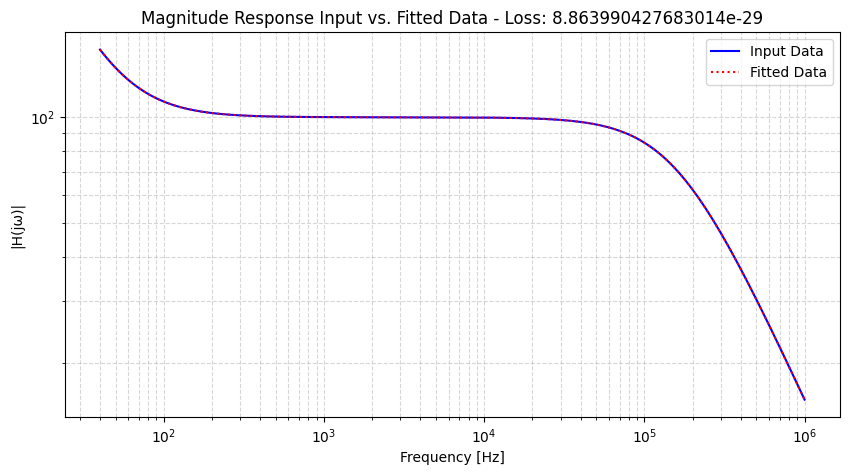

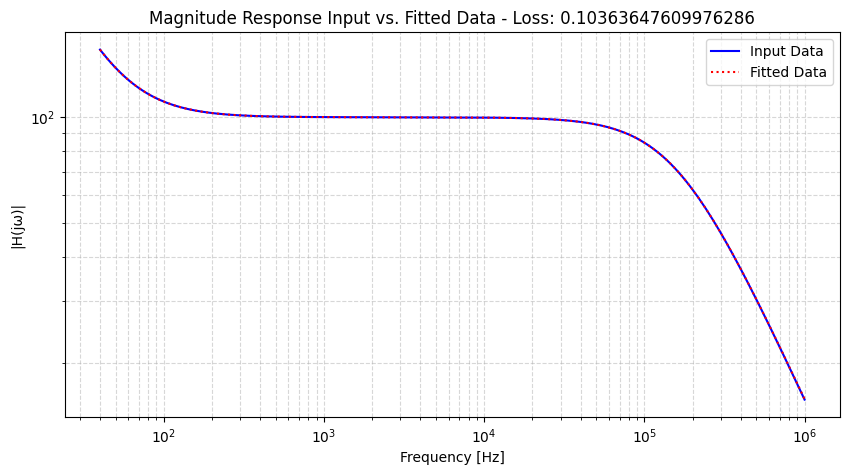

In [98]:
# param B0
b0_span = np.arange(-300.0*k, 300.0*k, 3e9)
losses_b0 = []
print("Parameter B0:")
for val in b0_span:
    test_params = [a0, a1, a2, val, b1, b2]
    loss_b0 = loss_function_complex(test_params, freq, magphase_complex, order=2,plotloss=None)
    losses_b0.append(loss_b0)

# param B1
b1_span = np.arange(-k, k, 1e7)
losses_b1 = []
print("Parameter B1:")
for val in b1_span:
    test_params = [a0, a1, a2, b0, val, b2]
    loss_b1 = loss_function_complex(test_params, freq, magphase_complex, order=2,plotloss=True)
    losses_b1.append(loss_b1)

# param B2
b2_span = np.arange(0, 2, 0.25)
losses_b2 = []
print("Parameter B2:")
for val in b2_span:
    test_params = [a0, a1, a2, b0, b1, val]
    loss_b2 = loss_function_complex(test_params, freq, magphase_complex, order=2,plotloss=True)
    losses_b2.append(loss_b2)

**Plot all parameters**

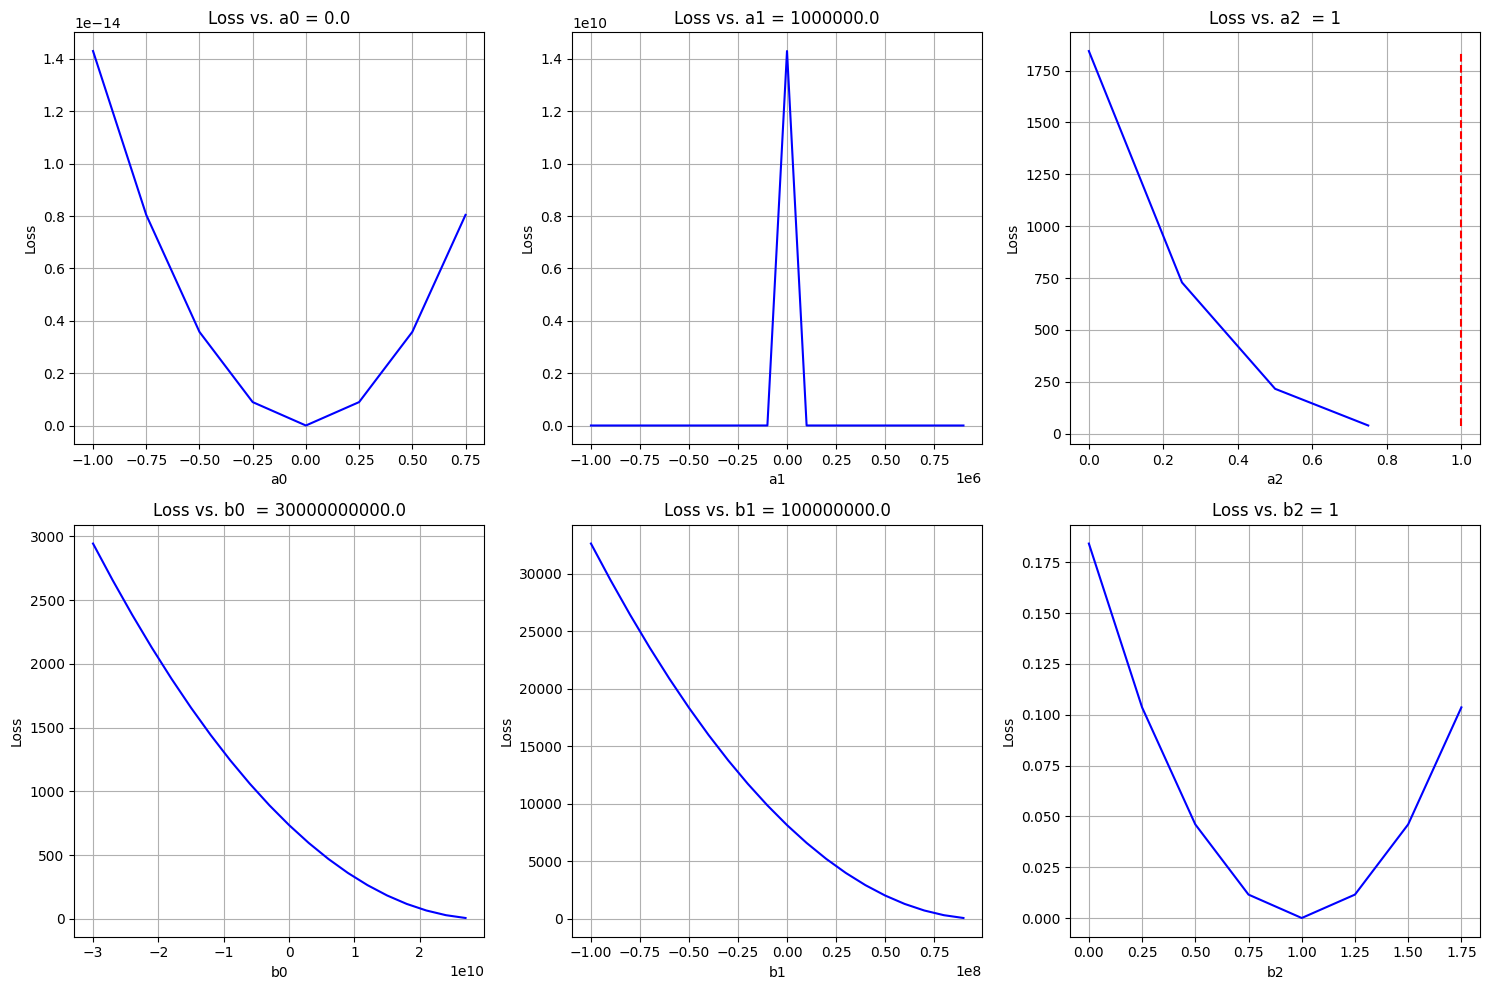

In [99]:
fig, axex = plt.subplots(2, 3, figsize=(15, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axex.flatten()

ax1.plot(a0_span, losses_a0, 'b-')
ax1.set_title(f'Loss vs. a0 = {a0}')
ax1.set_xlabel('a0')
ax1.set_ylabel('Loss')
ax1.grid()

ax2.plot(a1_span, losses_a1, 'b-')
ax2.set_title(f'Loss vs. a1 = {a1}')
ax2.set_xlabel('a1')
ax2.set_ylabel('Loss')
ax2.grid()

ax3.plot(a2_span, losses_a2, 'b-')
ax3.set_title(f'Loss vs. a2  = {a2}')
ax3.vlines(x=a2, ymin=min(losses_a2), ymax=max(losses_a2), colors='r', linestyles='dashed')
ax3.set_xlabel('a2')
ax3.set_ylabel('Loss')
ax3.grid()

ax4.plot(b0_span, losses_b0, 'b-')
ax4.set_title(f'Loss vs. b0  = {b0}')
ax4.set_xlabel('b0')
ax4.set_ylabel('Loss')
ax4.grid()

ax5.plot(b1_span, losses_b1, 'b-')
ax5.set_title(f'Loss vs. b1 = {b1}')
ax5.set_xlabel('b1')
ax5.set_ylabel('Loss')
ax5.grid()

ax6.plot(b2_span, losses_b2, 'b-')
ax6.set_title(f'Loss vs. b2 = {b2}')
ax6.set_xlabel('b2')
ax6.set_ylabel('Loss')
ax6.grid()

plt.tight_layout()
plt.show()


# **MINIMIZE METHOD**

**Synthetic data**

In [144]:
initial_guess = [0.0, 10e5, 1, 300.0*k, k, 1]   # a1, a2, b0, b1, b2 for second order TF

result = minimize(
    loss_function_complex,
    initial_guess,
    args=(freq, magphase_complex, order),
    method='Nelder-Mead',
    options={'maxiter': 10000, 'disp': True, 'xatol': 1e-6, 'fatol': 1e-6})

print(result)

optimized_params_synt1 = result.x
H, mag_fit_synt1, phase_fit_synt1 = coef2spectrum(optimized_params_synt1,freq,order=order)
pltFit(freq, mag_data, mag_fit_synt1, phase_data, phase_fit_synt1)

Loss: 8.863990427683014e-29
Loss: 8.936557333255345e-22
Loss: 19.132532475537843
Loss: 1.1433726576613612
Loss: 1.84011711934336
Loss: 20.393934395566102
Loss: 0.00046060656044339624
Loss: 35.07690946829477
Loss: 3.51129188470898
Loss: 31.041876349530977
Loss: 4.264421526785237
Loss: 8.447549610552175
Loss: 0.7673372075291852
Loss: 5.32793101533855
Loss: 0.7284181446411966
Loss: 1.9964673847613434
Loss: 0.45869212195479664
Loss: 1.2644920372301425
Loss: 0.2968311106043264
Loss: 1.5476505779869358
Loss: 0.13753687418790173
Loss: 1.081223998775724
Loss: 0.1625647235392801
Loss: 0.402250997773009
Loss: 0.1018847242131717
Loss: 0.2608000333488689
Loss: 0.060004602802247814
Loss: 0.3139339729430552
Loss: 0.027722012157636304
Loss: 0.20808289634706384
Loss: 0.030040733682874517
Loss: 0.10618931527503549
Loss: 0.026258599324485342
Loss: 0.06080013100000278
Loss: 0.015410275475287916
Loss: 0.05472679557470635
Loss: 0.006074161855761267
Loss: 0.04609940576839123
Loss: 0.0061694060768105645
Loss

**Experimental data**

**C0 - Air**

In [145]:
result_exp_C0 = minimize(
    loss_function_complex,
    initial_guess,
    args=(freq, magphase_complex_exp['C0.csv'], order),
    method='Nelder-Mead',
    options={'disp': True, 'xatol': 1e-6, 'fatol': 1e-6})

print(result_exp_C0)
optimized_params_exp_C0 = result_exp_C0.x

H_c0, mag_fit_exp_C0, phase_fit_exp_C0 = coef2spectrum(optimized_params_exp_C0,freq,order=order)
pltFit(freq, mag_exp['C0.csv'], mag_fit_exp_C0, phase_exp['C0.csv'], phase_fit_exp_C0)

Loss: 699765251076720.0
Loss: 699765251076720.0
Loss: 699765321708941.4
Loss: 699765250862470.2
Loss: 699765179331568.4
Loss: 699765248861117.9
Loss: 699765251079164.5
Loss: 699765146954240.1
Loss: 699765044963350.5
Loss: 699765161539362.4
Loss: 699765130301168.8
Loss: 699765087494144.8
Loss: 699765028617567.9
Loss: 699764902538924.6
Loss: 699764905549921.0
Loss: 699764879622862.1
Loss: 699764682928944.1
Loss: 699764738939828.8
Loss: 699764621736190.8
Loss: 699764261867891.9
Loss: 699764363912831.6
Loss: 699764159461265.4
Loss: 699763436966982.0
Loss: 699763790091737.5
Loss: 699763106385881.8
Loss: 699760183099452.1
Loss: 699761924322990.2
Loss: 699760050154926.0
Loss: 699721077228719.2
Loss: 699752215337633.6
Loss: 699845699895702.5
Loss: 699763216418703.0
Loss: 699724783909782.5
Loss: 699787231322042.0
Loss: 699761973924448.9
Loss: 699792157564288.2
Loss: 699761566252360.0
Loss: 699662089361169.9
Loss: 699778594807679.0
Loss: 699792809343915.5
Loss: 699759525465238.0
Loss: 6997877048

/tmp/ipython-input-2013386516.py:1: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result_exp_C0 = minimize(


**WATER**

In [146]:
result_exp_W = minimize(
    loss_function_complex,
    initial_guess,
    args=(freq, magphase_complex_exp['W.csv'], order),
    method='Nelder-Mead',
    options={'disp': True, 'xatol': 1e-6, 'fatol': 1e-6})

print(result_exp_W)
optimized_params_exp_W = result_exp_W.x

H_W, mag_fit_exp_W, phase_fit_exp_W = coef2spectrum(optimized_params_exp_W,freq,order=order)
pltFit(freq, mag_exp['W.csv'], mag_fit_exp_W, phase_exp['W.csv'], phase_fit_exp_W)

Loss: 1455.147849875754
Loss: 1455.1478498757308
Loss: 1605.5157809897753
Loss: 1503.5881902498652
Loss: 1416.430712205257
Loss: 1330.7128310618073
Loss: 1454.2092398610207
Loss: 1304.8924069236446
Loss: 1238.847925927266
Loss: 1254.1905695645694
Loss: 1250.1249795938331
Loss: 1205.3205384052646
Loss: 1158.2964584386873
Loss: 1159.6692425990466
Loss: 1217.9254438535297
Loss: 1211.6637651241954
Loss: 1349.057472367329
Loss: 1191.5454272016684
Loss: 1284.9448375360967
Loss: 1194.240421890486
Loss: 1119.7014694268596
Loss: 1096.663132005545
Loss: 1118.4448514909732
Loss: 1178.551447088602
Loss: 1068.3749891413775
Loss: 1020.9701284073999
Loss: 1053.3934726143655
Loss: 1235.3252663631797
Loss: 1110.0048851295187
Loss: 996.554077934777
Loss: 921.3342917834922
Loss: 923.0428655027488
Loss: 993.8833002937187
Loss: 1035.5340938899474
Loss: 860.313883685325
Loss: 757.7873026451359
Loss: 801.2937872827592
Loss: 901.5590735225826
Loss: 726.2330744102375
Loss: 610.4606175315798
Loss: 683.611076977

**ICE**

Loss: 9577.50319156905
Loss: 9577.503191567137
Loss: 10310.63044309273
Loss: 9655.62849272442
Loss: 9577.751757925564
Loss: 8768.149003214727
Loss: 9576.47216652798
Loss: 8563.256667338224
Loss: 7645.083020517746
Loss: 8590.700267799546
Loss: 8343.37024686419
Loss: 7931.226447313269
Loss: 7382.117367377971
Loss: 6292.127749962284
Loss: 6293.561070793252
Loss: 6186.951416690361
Loss: 4822.728168792974
Loss: 5204.164136638038
Loss: 4406.937987216859
Loss: 2667.972891565461
Loss: 3095.257583469734
Loss: 2194.9616079489915
Loss: 1511.464853013396
Loss: 1629.0302366998474
Loss: 2497.316225158502
Loss: 4105.646640061772
Loss: 12253.951877542273
Loss: 2676.75266769493
Loss: 4446.287881516401
Loss: 1678.5096245324726
Loss: 3298.2954341341156
Loss: 2124.1928438142327
Loss: 2850.0817242198855
Loss: 1928.8077361456922
Loss: 3600.6576957009747
Loss: 1886.5065418528147
Loss: 2614.4617615331304
Loss: 1638.857062610703
Loss: 2027.4541688389613
Loss: 1582.8288891154323
Loss: 2376.280948354235
Loss: 16

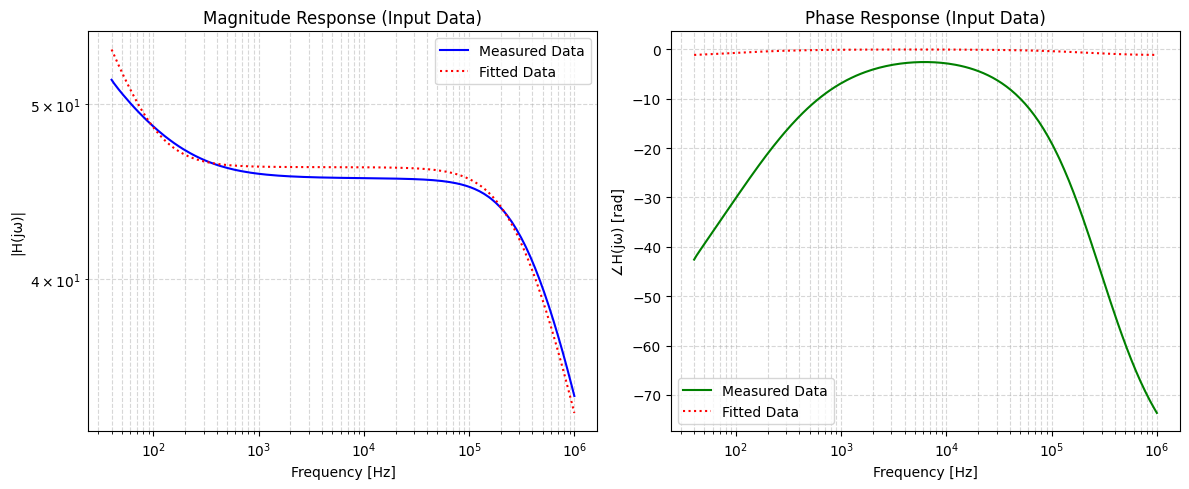

In [140]:
result_exp_ICE = minimize(
    loss_function_complex,
    initial_guess,
    args=(freq, magphase_complex_exp['ICE.csv'], order),method='Nelder-Mead',
    options={'maxiter': 10000, 'disp': True})

print(result_exp_ICE)
optimized_params_exp_ICE = result_exp_ICE.x

H_ICE, mag_fit_exp_ICE, phase_fit_exp_ICE = coef2spectrum(optimized_params_exp_ICE,freq,order=order)
pltFit(freq, mag_exp['ICE.csv'], mag_fit_exp_ICE, phase_exp['ICE.csv'], phase_fit_exp_ICE)

# **References**



1.   https://joss.theoj.org/papers/10.21105/joss.02349.pdf
2.   https://impedancepy.readthedocs.io/en/latest/getting-started.html

scipy.minimize
https://docs.scipy.org/doc/scipy/reference/optimize.minimize-newtoncg.html#optimize-minimize-newtoncg